In [50]:
from ursse.utils import normalize, myhist
import ursse.sync_motion_simulation as sms
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import valstore as vt
import os
from config_ursse import get_from_config
images_dir = os.path.join(get_from_config("URSSE_sync_motion_note_dir"),
                          "images")

In [2]:
rf_noise_std=7e-5
rf_label = "6.0e-05"
model = sms.Model(rf_noise_std=rf_noise_std)
fp = model.simulate(load=rf_label)

working on 1 out of 5
working on 2 out of 5
working on 3 out of 5
working on 4 out of 5
working on 5 out of 5


In [3]:
model.spad_tts = 0.4
model.add_spad_tts_do_fitting_and_binning(verbose=True)
res = {}
features = ['amplitude', 'rms_length', 'slow_phase', 'kick_to_amplitude']
nbins_arr = [40, 40, 20, 40]
for feat, nbins in zip(features, nbins_arr):
    res[feat] = model.get_meas_sim_comparison(feature=feat, nbins=nbins)
res['amp_per_corr'] = model.get_meas_sim_amp_period_corr()

working on file number 1 out of 5
working on file number 2 out of 5
working on file number 3 out of 5
working on file number 4 out of 5
working on file number 5 out of 5


In [4]:
x = res['amplitude']['bin_centers']
y = normalize(res['amplitude']['aggregated_hists']['meas'])/(x[1]-x[0])
sz = np.sqrt(np.average(x**2/2, weights=y))
sz

0.522790939188054

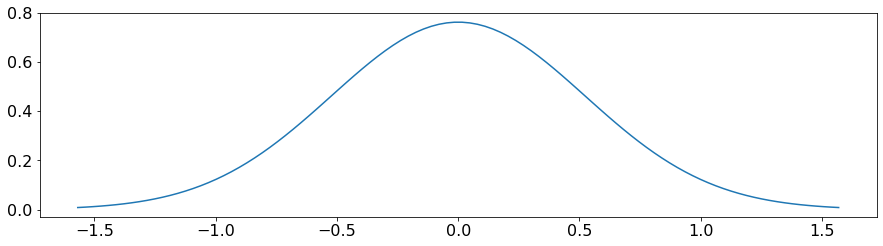

In [5]:
x = np.linspace(-3*sz, 3*sz, 100)
plt.plot(x, norm.pdf(x, 0, sz))

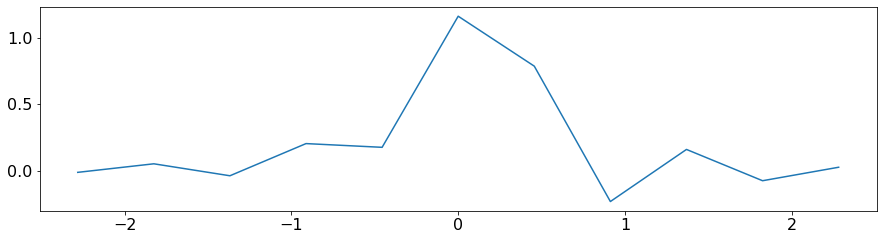

In [6]:
delays_list = [a['meas_df']['delay'].values for a in fp]
delays = np.concatenate(delays_list)
m = 5
rt, bins = np.histogram(delays, bins=2*m+1, density=True)
bin_centers = (bins[1:]+bins[:-1])/2
dz = bins[1]-bins[0]
n = len(bin_centers)
# plt.plot(bin_centers, rt)

pz = normalize(np.diff(norm.cdf(bins, 0, sz)))/dz

t = np.arange(n)
z = np.arange(n)
j = np.arange(n)-m
t2d, z2d = np.meshgrid(t, z, indexing='ij')

aux_tzj = np.repeat((t2d-z2d)[None,:,:], n, axis=0)


j3d = np.repeat(j, n**2, axis=0).reshape(n,n,n)

delta_tzj = (aux_tzj == j3d).astype(int)

Atj = dz*np.einsum('z,tzj', pz, delta_tzj)
q = np.linalg.inv(Atj) @ rt
plt.plot( dz*j, q )

0.6549131465043189

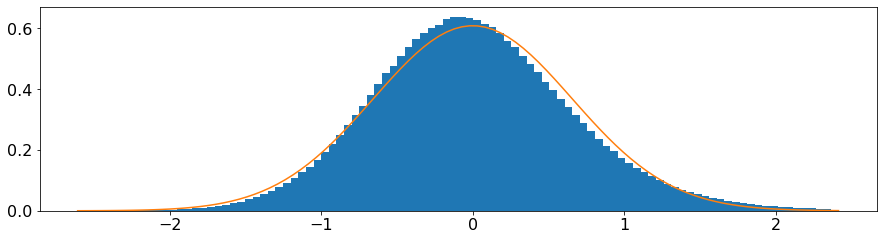

In [7]:
mu = np.mean(delays)
si = np.std(delays)
plt.hist(delays, bins=100, density=True)
xs = np.linspace(min(delays), max(delays), 100)
plt.plot(xs, norm.pdf(xs, mu, si))
si

In [8]:
from scipy.stats import skew
skew(delays)

0.256850196426258

In [9]:
from scipy.stats import skewtest
skewtest(delays)

SkewtestResult(statistic=198.9927879076115, pvalue=0.0)

## Distribution of residuals between the real arrival times and the sinusoidal fits

In [10]:
import scipy.interpolate

In [11]:
idx = 0

In [12]:
df0 = fp[idx]['meas_df']
T0 = 2372
fitper=20
overlapper=3
nper_step=10

def f(t, a0, A, B, T):
    return a0 + A*np.cos(2*np.pi/T*t)+B*np.sin(2*np.pi/T*t)


fitrange = T0*fitper
overlaprange = T0*overlapper
starts = df0.groupby(((df0['revolution'].values)//(fitrange-overlaprange)).astype(int))\
    .apply(lambda v: v.index.values[0]).values
ends = df0.groupby(((df0['revolution'].values-overlaprange)//(fitrange-overlaprange)).astype(int))\
    .apply(lambda v: v.index.values[-1]).values[1:]
nintervals = min(len(starts), len(ends))
starts = starts[:nintervals]
ends = ends[:nintervals]


alist, blist = [],[]
for s,e in zip(starts, ends):
    v = df0.loc[s:e,:]
    x = v['revolution'].values
    y = v['delay'].values
    A = np.vstack([np.cos(2*np.pi/T0*x),np.sin(2*np.pi/T0*x)]).T
    a,b = np.linalg.lstsq(A, y, rcond=None)[0]
    alist.append(a)
    blist.append(b)


fits_df = pd.DataFrame({'start_idx': starts, 'end_idx': ends,
                        'A': alist, 'B': blist})
fits_df_len = len(fits_df.index)
fits_df['start_revolution'] = df0.loc[starts, 'revolution']\
    .reset_index(drop=True)
fits_df['end_revolution'] = df0.loc[ends, 'revolution']\
    .reset_index(drop=True)
fits_df['next_start_revolution'] = fits_df['start_revolution']\
    .shift(-1).values.astype(int)
fits_df['previous_end_revolution'] = fits_df['end_revolution']\
    .shift(1).values.astype(int)
fits_df.loc[fits_df_len-1, 'next_start_revolution'] = \
    fits_df.loc[fits_df_len-1, 'end_revolution']
fits_df.loc[0, 'previous_end_revolution'] = \
    fits_df.loc[0, 'start_revolution']
fits_df['next_A'] = fits_df['A'].shift(-1)
fits_df['next_B'] = fits_df['B'].shift(-1)

def get_one_fit(row):
    revs = np.arange(row['previous_end_revolution'],
                        row['end_revolution'],
                        nper_step)

    def interpAB(val1, val2):
        return np.interp(
            revs,
            [
                row['previous_end_revolution'],
                row['next_start_revolution'],
                row['end_revolution']
            ],
            [val1, val1, val2]
        )
    avals = interpAB(row['A'], row['next_A'])
    bvals = interpAB(row['B'], row['next_B'])
    dels = f(revs, 0, avals, bvals, T0)
    return pd.DataFrame({'revolution': revs.astype(int), 'delay': dels})

res = fits_df.apply(get_one_fit, axis=1)
res = pd.concat(res.to_list(), ignore_index=True, sort=False)

new_revs = np.arange(0, res['revolution'].max(), nper_step)
new_dels = scipy.interpolate.interp1d(res['revolution'], res['delay'],
                        bounds_error=False,
                        fill_value="extrapolate")(new_revs)
res = pd.DataFrame({'revolution': new_revs, 'delay': new_dels})

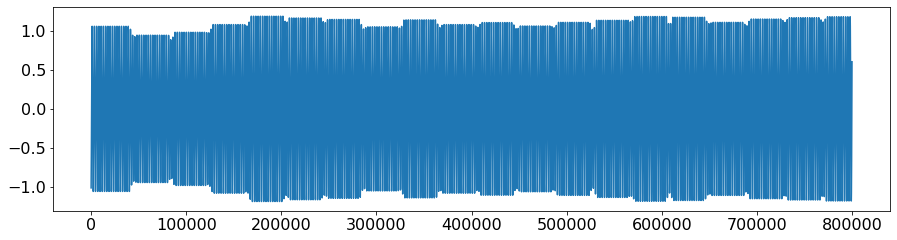

In [13]:
resplot = res.loc[:80000, :]
plt.plot(resplot['revolution'], resplot['delay'])

In [14]:
fit_delays = np.interp(fp[idx]['meas_df']['revolution'], res['revolution'], res['delay'])
residuals = fp[idx]['meas_df']['delay'].values - fit_delays

In [15]:
from scipy.stats import gamma

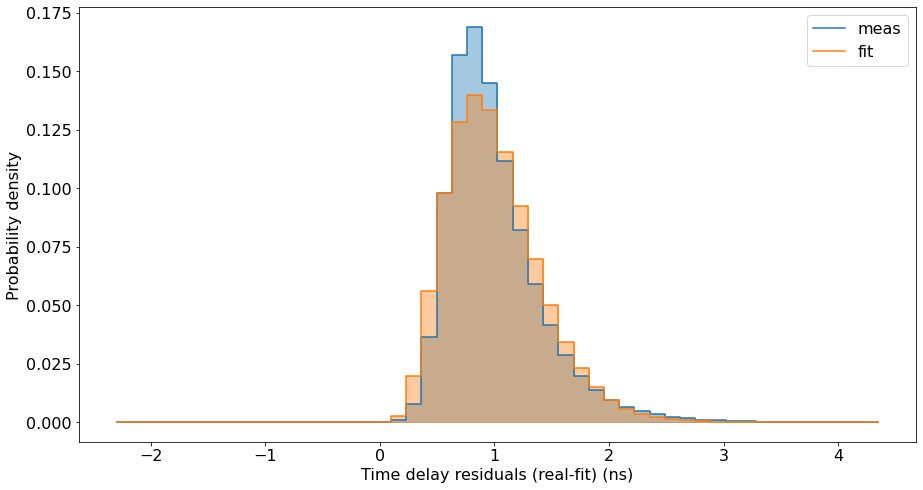

In [33]:
fig, ax = plt.subplots(figsize=(15,8))

shift = 1
residuals1 = residuals + shift
vals, bins = np.histogram(residuals1, bins=50)
q = normalize(vals)
x = (bins[1:]+bins[:-1])/2
myhist(ax, x, q, label="meas")

av = np.mean(residuals1)
std = np.std(residuals1)

a = 1/(std/av)**2
scale = av/a

p = np.diff(gamma.cdf(bins, a, loc=0, scale=scale))
myhist(ax, x, p, label="fit")

ax.legend()
ax.set_ylabel("Probability density")
ax.set_xlabel("Time delay residuals (real-fit) (ns)")
plt.show()

The above is an approximate distribution for the SPAD's delay.

In [34]:
def loss(shift):
    residuals1 = residuals + shift
    vals, bins = np.histogram(residuals1, bins=50)
    q = normalize(vals)
    x = (bins[1:]+bins[:-1])/2
    myhist(ax, x, q, label="meas")

    av = np.mean(residuals1)
    std = np.std(residuals1)

    a = 1/(std/av)**2
    scale = av/a

    p = np.diff(gamma.cdf(bins, a, loc=0, scale=scale))
    
    df0 = pd.DataFrame({"p": p, "q": q})
    df = df0[df0['p'] > 0]
    DKL = np.sum(df['p']*np.log(df['p']/df['q']))
    return DKL

loss(1)

0.023548381645959335

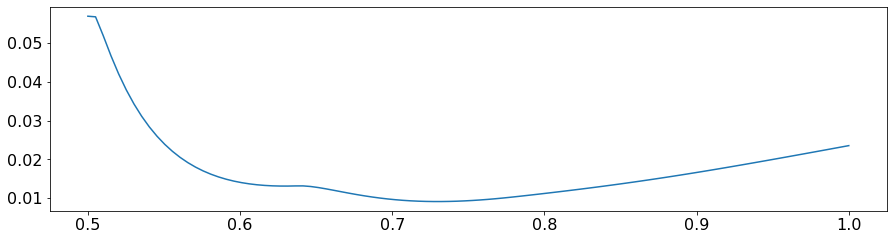

In [35]:
shifts = np.linspace(0.5,1.0,100)
losses = [loss(shift) for shift in shifts]
plt.plot(shifts, losses)

In [36]:
best_shift = shifts[np.argmin(losses)]
best_shift

0.7272727272727273

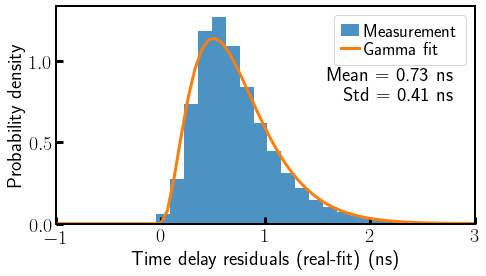

In [63]:
from ursse.path_assistant import get_plot_style_sheet
plt.style.use(get_plot_style_sheet("jinst"))

fig, ax = plt.subplots(figsize=(7.5,4))

residuals1 = residuals + best_shift
vals, bins, _ = ax.hist(residuals1, bins=50, density=True, label="Measurement", alpha=0.8)
x = (bins[1:]+bins[:-1])/2

av = np.mean(residuals1)
std = np.std(residuals1)

a = 1/(std/av)**2
scale = av/a

xgamma = np.linspace(min(x), max(x), 100)
ax.plot(xgamma, gamma.pdf(xgamma, a, loc=0, scale=scale), linewidth=3, label="Gamma fit")

ax.set_xlim(-1, 3)


subtitlepos = 0.95, 0.55
ax.text(*subtitlepos, f"Mean = {av:.2f} ns"\
                      + "\n" + f"Std = {std:.2f} ns",
         transform=ax.transAxes,
         va='bottom', ha='right')

ax.set_ylabel("Probability density")
ax.set_xlabel("Time delay residuals (real-fit) (ns)")
handles, labels = ax.get_legend_handles_labels()
order = [1, 0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
fig.savefig(os.path.join(images_dir,
                             "reconstructed_spad_dist.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [65]:
vt.newval("ReconstructedSpadMean", av, "{:.2f}", "ns")
vt.newval("ReconstructedSpadStd", std, "{:.2f}", "ns")
vt.newval("ReconstructedSpadShift", best_shift, "{:.2f}", "ns")